# Evaluación - Aprendizaje NO supervisado

**Integrante 1:**
DESHI

**Correo Electrónico integrante 1:**
NULL

---

## Descripción

Este notebook contiene la evaluación asociada a Modelos de Segmentación de la asignatura de Inteligencia Artificial de la carrera de Ingeniería Civil en informática de la UBB.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)
- sklearn (1.3.2)
- kneed-0.8.5

# Descripción de los datos

Number of observations: 6366
Number of variables: 9
Variable name definitions:

    rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                    4 = good, 5 = very good
    age             : Age
    yrs_married     : No. years married. Interval approximations. See
                    original paper for detailed explanation.
    children        : No. children
    religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                    4 = strongly
    educ            : Level of education, 9 = grade school, 12 = high
                    school, 14 = some college, 16 = college graduate,
                    17 = some graduate school, 20 = advanced degree
    occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                    or unskilled worker; 3 = white-colloar; 4 = teacher
                    counselor social worker, nurse; artist, writers;
                    technician, skilled worker, 5 = managerial,
                    administrative, business, 6 = professional with
                    advanced degree
    occupation_husb : Husband's occupation. Same as occupation.
    affairs         : measure of time spent in extramarital affairs

See the original paper for more details.

Fair, Ray. 1978. “A Theory of Extramarital Affairs,” Journal of Political Economy, February, 45-61.

The data is available at http://fairmodel.econ.yale.edu/rayfair/pdf/2011b.htm

In [1]:
# Descargar el archivo
!wget https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/main/data/affairs.csv

--2024-11-21 18:33:12--  https://raw.githubusercontent.com/JaznaLaProfe/InteligenciaArtificial/main/data/affairs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286041 (279K) [text/plain]
Saving to: ‘affairs.csv’

affairs.csv         100%[===================>] 279.34K  --.-KB/s    in 0.007s  

2024-11-21 18:33:12 (40.6 MB/s) - ‘affairs.csv’ saved [286041/286041]



In [2]:
!pip install kneed

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.base import TransformerMixin

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

# Carga de datos

In [4]:
data_affair = pd.read_csv("affairs.csv")
data_affair.shape

(6366, 10)

In [5]:
data_affair.head(7)

,Unnamed: 0,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666
5,5,4.0,27.0,9.0,0.0,2.0,14.0,3.0,4.0,4.666666
6,6,5.0,37.0,23.0,5.5,2.0,12.0,5.0,4.0,0.852174


# Análisis preliminar de los datos

In [6]:
data_affair.dtypes

,0
Unnamed: 0,int64
rate_marriage,float64
age,float64
yrs_married,float64
children,float64
religious,float64
educ,float64
occupation,float64
occupation_husb,float64
affairs,float64


**COMENTARIOS**

Hay presente 9 variables cualitativas.

In [7]:
data_affair.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       6366 non-null   int64  
 1   rate_marriage    6366 non-null   float64
 2   age              6366 non-null   float64
 3   yrs_married      6366 non-null   float64
 4   children         6366 non-null   float64
 5   religious        6366 non-null   float64
 6   educ             6366 non-null   float64
 7   occupation       6366 non-null   float64
 8   occupation_husb  6366 non-null   float64
 9   affairs          6366 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 497.5 KB


**COMENTARIOS**

No existen valores nulos.

In [8]:
data_cleaned = data_affair.drop(columns=["Unnamed: 0"])

**COMENTARIOS**

Eliminamos la columna irrelevante.

In [9]:
data_cleaned.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


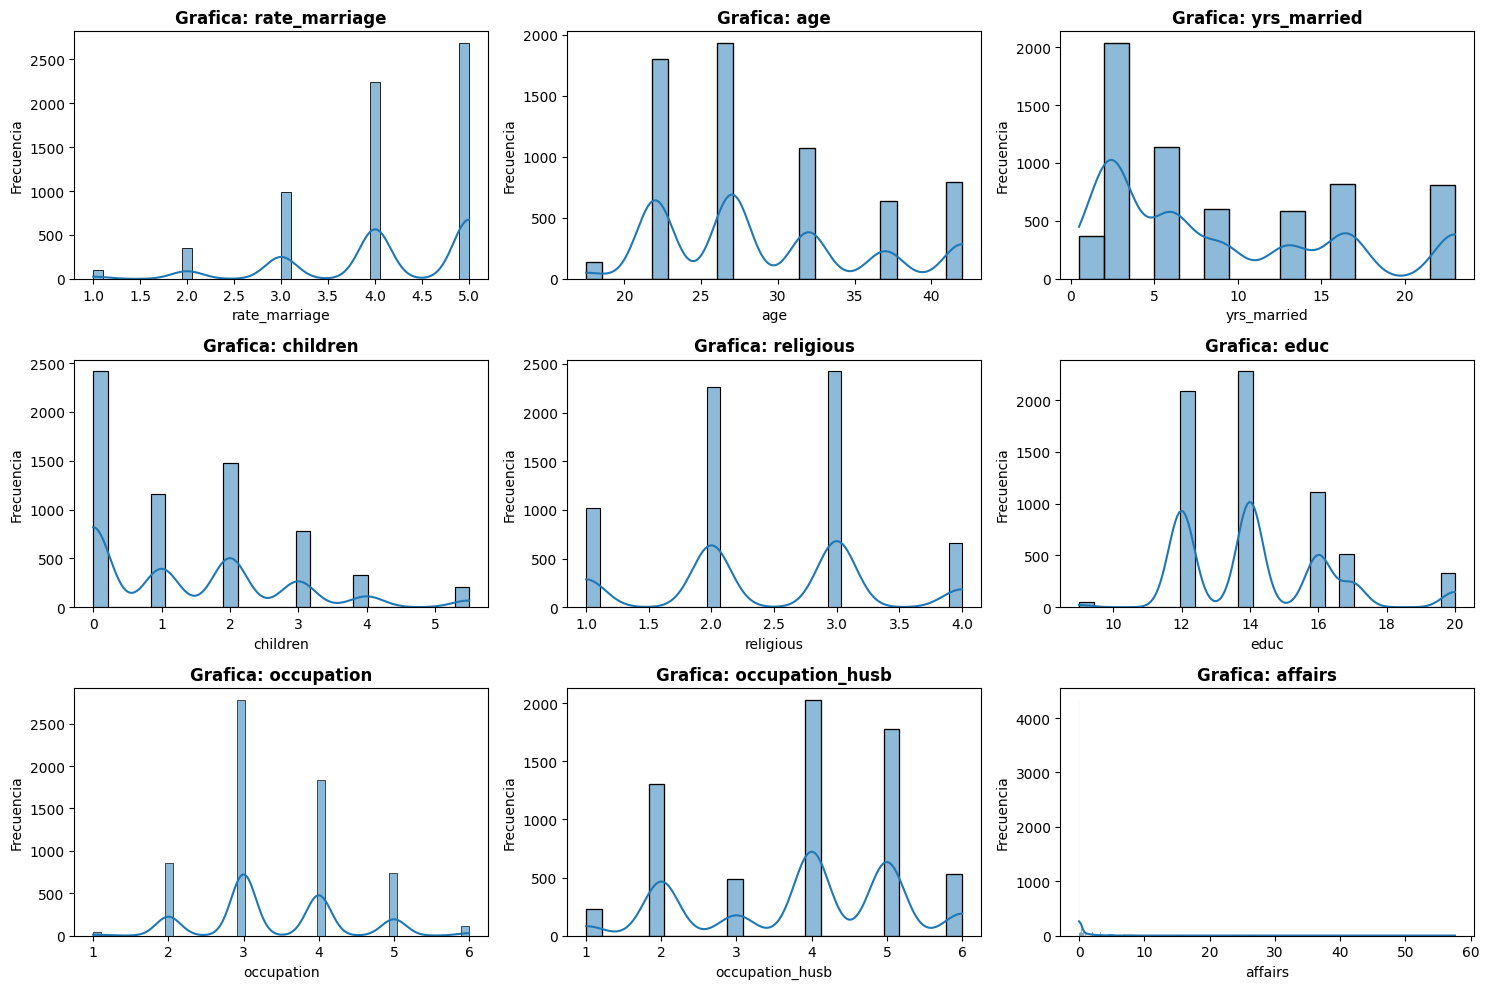

In [10]:
columns_graficadas = [
    "rate_marriage", "age", "yrs_married", "children", "religious", "educ", "occupation", "occupation_husb", "affairs"
]
num_cols = 3
num_rows = int(len(columns_graficadas) / num_cols) + (len(columns_graficadas) % num_cols > 0)

plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_graficadas, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(data_cleaned[col], kde=True)
    plt.title(f"Grafica: {col}", fontweight="bold")
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

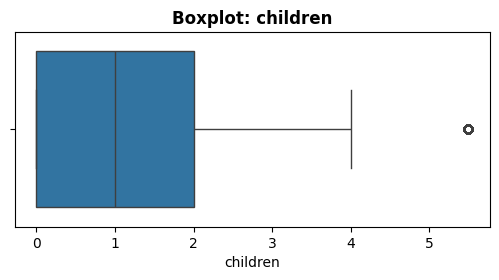

In [11]:
columns_chequeadas = [
    "children"
]

plt.figure(figsize=(10, 5))
for i, col in enumerate(columns_chequeadas, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=data_cleaned, x=col)
    plt.title(f"Boxplot: {col}", fontweight="bold")
plt.tight_layout()

plt.show()

In [12]:
def eliminar_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

data_no_outliers = data_cleaned.copy()

for col in columns_chequeadas:
    data_no_outliers = eliminar_outliers_iqr(data_no_outliers, col)

data_no_outliers

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666
...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.000000
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.000000
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.000000
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.000000


**COMENTARIOS**

Eliminamos los outliers de las columnas chequeadas para una mejor visualización de los valores reales.

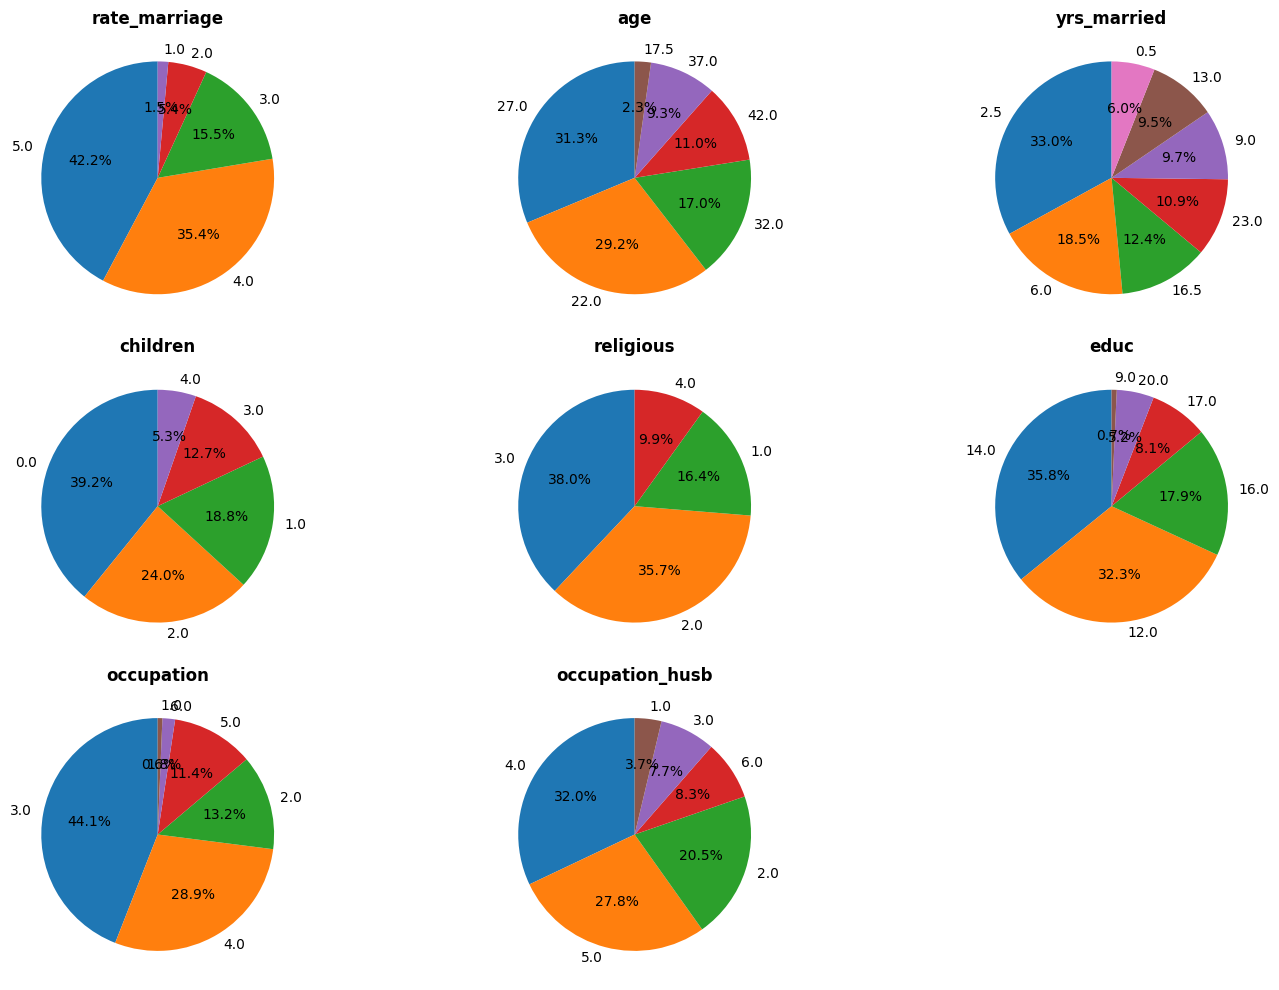

In [13]:
cols_pie = ['rate_marriage', 'age', 'yrs_married', 'children', 'religious', 'educ', 'occupation', 'occupation_husb']

plt.figure(figsize=(15, 10))

for i, col in enumerate(cols_pie):
    plt.subplot(3, 3, i + 1)
    value_counts = data_no_outliers[col].value_counts(normalize=True) * 100
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'{col}', fontweight="bold")

plt.tight_layout()
plt.show()

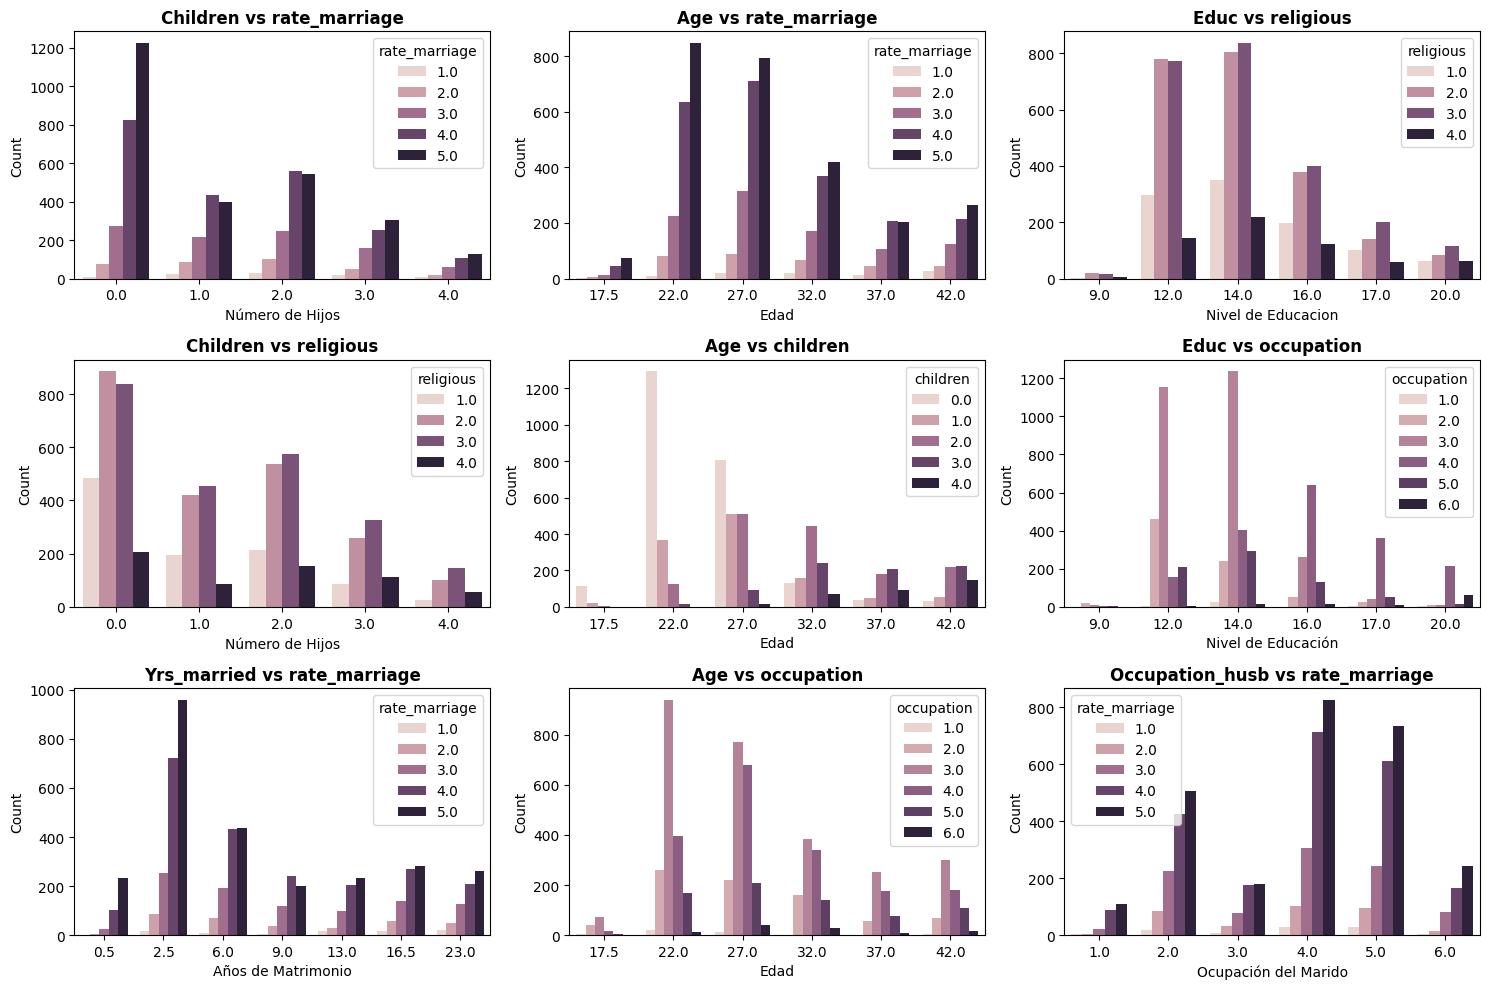

In [14]:
num_cols=3
num_filas=3
plt.figure(figsize=(15, 10))

plt.subplot(num_rows, num_cols, 1)
sns.countplot(data=data_no_outliers, x='children', hue='rate_marriage')
plt.title('Children vs rate_marriage', fontweight='bold')
plt.xlabel('Número de Hijos')
plt.ylabel('Count')

plt.subplot(num_rows, num_cols, 2)
sns.countplot(data=data_no_outliers, x='age', hue='rate_marriage')
plt.title('Age vs rate_marriage', fontweight='bold')
plt.xlabel('Edad')
plt.ylabel('Count')

plt.subplot(num_rows, num_cols, 3)
sns.countplot(data=data_no_outliers, x='educ', hue='religious')
plt.title('Educ vs religious', fontweight='bold')
plt.xlabel('Nivel de Educacion')
plt.ylabel('Count')

plt.subplot(num_rows, num_cols, 4)
sns.countplot(data=data_no_outliers, x='children', hue='religious')
plt.title('Children vs religious', fontweight='bold')
plt.xlabel('Número de Hijos')
plt.ylabel('Count')

plt.subplot(num_rows, num_cols, 5)
sns.countplot(data=data_no_outliers, x='age', hue='children')
plt.title('Age vs children', fontweight='bold')
plt.xlabel('Edad')
plt.ylabel('Count')

plt.subplot(num_rows, num_cols, 6)
sns.countplot(data=data_no_outliers, x='educ', hue='occupation')
plt.title('Educ vs occupation', fontweight='bold')
plt.xlabel('Nivel de Educación')
plt.ylabel('Count')

plt.subplot(num_rows, num_cols, 7)
sns.countplot(data=data_no_outliers, x='yrs_married', hue='rate_marriage')
plt.title('Yrs_married vs rate_marriage', fontweight='bold')
plt.xlabel('Años de Matrimonio')
plt.ylabel('Count')

plt.subplot(num_rows, num_cols, 8)
sns.countplot(data=data_no_outliers, x='age', hue='occupation')
plt.title('Age vs occupation', fontweight='bold')
plt.xlabel('Edad')
plt.ylabel('Count')

plt.subplot(num_rows, num_cols, 9)
sns.countplot(data=data_no_outliers, x='occupation_husb', hue='rate_marriage')
plt.title('Occupation_husb vs rate_marriage', fontweight='bold')
plt.xlabel('Ocupación del Marido')
plt.ylabel('Count')



plt.tight_layout()
plt.show()


**COMENTARIOS**

Respecto a la última gráfica podemos deducir y visualizar posibles clusters para tener en cuenta:

* Las personas que tienen 0 hijos suelen tener un matrimonio muy bueno.
* Los que tienen 22-27 años suelen tener un matrimonio muy bueno.
* Los que tienen 22-27 años no suelen tener hijos.
* Los que creen en una religión (rango 2-3) no suelen tener hijos.
* Los que tienen nivel de educación rango 12-14-16 suelen creer en una religión (rango 2-3)
* Los que tienen nivel de educación 12-14 suelen tener un trabajo formal o de oficina.
* Los que llevan 2 años y medio de casados suelen tener un matrimonio muy bueno.
* Los que tienen un trabajo de rango 4-5 suelen tener un matrimonio muy bueno.
* Los que tienen 22-27 años suelen tener trabajos de oficina/formal.


Ahora podemos comenzar a identificar patrones que definen un conjunto de grupos que representan a los individuos.

`Grupo 1: Personas jóvenes, recién casadas y sin hijos`

    Características:
        Edad: 22-27 años.
        Matrimonio muy bueno.
        No tienen hijos.
        Trabajos de oficina/formales (rango 4-5).

  Este grupo representa parejas jóvenes satisfacción matrimonial muy buena, enfocados en sus carreras.

`Grupo 2: Personas con matrimonio muy bueno y trabajos avanzados`

    Características:
        Trabajo en rango 4-5.
        Matrimonio muy bueno.
        Pueden tener pocos hijos o ninguno.

  Este grupo representa personas con estabilidad tanto en sus relaciones como en su carrera profesional.

Por supuesto que habrán muchos grupos más, que iremos analizando respecto a los modelos de segmentación.


## ELIMINACION DE VARIABLES

In [15]:
data_no_outliers_cleaned = data_no_outliers.copy()

#data_no_outliers_cleaned = data_no_outliers_cleaned.drop(columns=["affairs"]) ##
#data_no_outliers_cleaned = data_no_outliers_cleaned.drop(columns=["educ"]) ##
#data_no_outliers_cleaned = data_no_outliers_cleaned.drop(columns=["occupation_husb"]) ##
#data_no_outliers_cleaned = data_no_outliers_cleaned.drop(columns=["age"])
#data_no_outliers_cleaned = data_no_outliers_cleaned.drop(columns=["yrs_married"])
#data_no_outliers_cleaned = data_no_outliers_cleaned.drop(columns=["children"])
#data_no_outliers_cleaned = data_no_outliers_cleaned.drop(columns=["rate_marriage"])
#data_no_outliers_cleaned = data_no_outliers_cleaned.drop(columns=["religious"]) ##
#data_no_outliers_cleaned = data_no_outliers_cleaned.drop(columns=["occupation"]) ##

data_no_outliers_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
rate_marriage,6163.0,4.115528,0.954647,1.0,4.0,4.0,5.000000,5.000000
age,6163.0,28.748256,6.668085,17.5,22.0,27.0,32.000000,42.000000
yrs_married,6163.0,8.622668,7.044093,0.5,2.5,6.0,13.000000,23.000000
children,6163.0,1.261723,1.244843,0.0,0.0,1.0,2.000000,4.000000
religious,6163.0,2.414733,0.876683,1.0,2.0,2.0,3.000000,4.000000
educ,6163.0,14.229109,2.172850,9.0,12.0,14.0,16.000000,20.000000
occupation,6163.0,3.425442,0.938596,1.0,3.0,3.0,4.000000,6.000000
occupation_husb,6163.0,3.845205,1.347117,1.0,3.0,4.0,5.000000,6.000000
affairs,6163.0,0.716922,2.234433,0.0,0.0,0.0,0.484848,57.599991


**COMENTARIOS**

Intenté varias combinaciones, pero consideré que era mejor añadir todas las variables, ya que el punto es tratar de organizar los grupos con los modelos.

## Escalamiento usando MinMaxScaler (TÉCNICA 1)

In [16]:
data_cleaned_1= data_no_outliers_cleaned.copy()

In [17]:
# Escalar datos con MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_cleaned_1)

data_scaled = pd.DataFrame(data_scaled, columns=data_cleaned_1.columns, index=data_cleaned_1.index)

data_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
rate_marriage,6163.0,0.778882,0.238662,0.0,0.750000,0.750000,1.000000,1.0
age,6163.0,0.459112,0.272167,0.0,0.183673,0.387755,0.591837,1.0
yrs_married,6163.0,0.361007,0.313071,0.0,0.088889,0.244444,0.555556,1.0
children,6163.0,0.315431,0.311211,0.0,0.000000,0.250000,0.500000,1.0
religious,6163.0,0.471578,0.292228,0.0,0.333333,0.333333,0.666667,1.0
educ,6163.0,0.475374,0.197532,0.0,0.272727,0.454545,0.636364,1.0
occupation,6163.0,0.485088,0.187719,0.0,0.400000,0.400000,0.600000,1.0
occupation_husb,6163.0,0.569041,0.269423,0.0,0.400000,0.600000,0.800000,1.0
affairs,6163.0,0.012447,0.038792,0.0,0.000000,0.000000,0.008418,1.0


## Escalamiento usando RobustScaler (TÉCNICA 2)

In [18]:
data_cleaned_2= data_no_outliers_cleaned.copy()

In [19]:
scaler = RobustScaler()

data_robust = scaler.fit_transform(data_cleaned_2)
data_robust = pd.DataFrame(data_robust, columns=data_cleaned_2.columns, index=data_cleaned_2.index)

data_robust.describe().T

,count,mean,std,min,25%,50%,75%,max
rate_marriage,6163.0,0.115528,0.954647,-3.00000,0.000000,0.0,1.000000,1.000000
age,6163.0,0.174826,0.666808,-0.95000,-0.500000,0.0,0.500000,1.500000
yrs_married,6163.0,0.249778,0.670866,-0.52381,-0.333333,0.0,0.666667,1.619048
children,6163.0,0.130862,0.622421,-0.50000,-0.500000,0.0,0.500000,1.500000
religious,6163.0,0.414733,0.876683,-1.00000,0.000000,0.0,1.000000,2.000000
educ,6163.0,0.057277,0.543212,-1.25000,-0.500000,0.0,0.500000,1.500000
occupation,6163.0,0.425442,0.938596,-2.00000,0.000000,0.0,1.000000,3.000000
occupation_husb,6163.0,-0.077397,0.673558,-1.50000,-0.500000,0.0,0.500000,1.000000
affairs,6163.0,1.478651,4.608518,0.00000,0.000000,0.0,1.000000,118.800002


# MODELOS DE SEGMENTACIÓN

## **INERCIAS**

### (TÉCNICA 1)

**COMENTARIOS**

Usando los datos escalados con la técnica 1 y valor por defecto de init

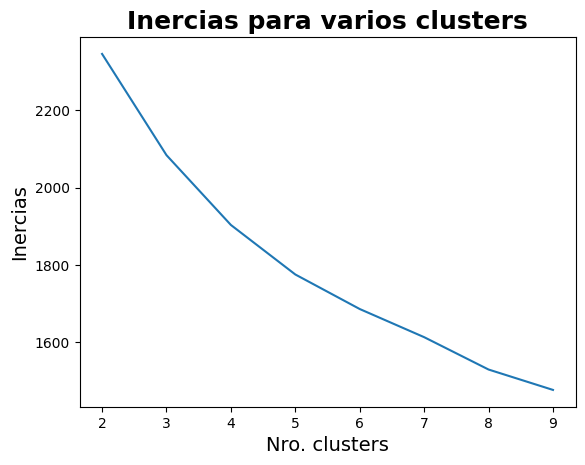

In [20]:
X=data_scaled

inertias = []
n_clusters_iterable = range(2,10)
for n_clusters in n_clusters_iterable:
    model_kmeans = KMeans(n_clusters=n_clusters, random_state=29) # Instanciamos el algoritmo de k-means
    model_kmeans.fit(X.iloc[:,:9]) # Ajustamos el modelo de k-means
    inertias.append(model_kmeans.inertia_) # Esta la dispersión de nuestros grupos

# Usando los datos escalados con la técnica 1 y valor por defecto de init
plt.plot(n_clusters_iterable, inertias)
plt.title("Inercias para varios clusters", fontsize=18, fontweight = "bold")
plt.xlabel("Nro. clusters", fontsize=14)
plt.ylabel("Inercias", fontsize=14)
plt.show()

**COMENTARIOS**

Usando los datos escalados con la técnica 1 y valor asignado a init

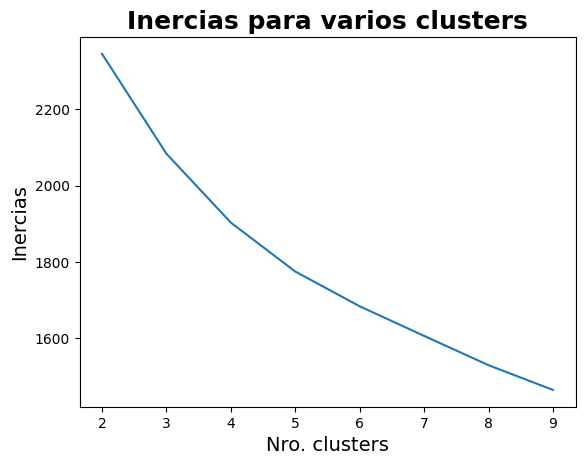

In [21]:
X=data_scaled

inertias_random = []
n_clusters_iterable = range(2,10)
for n_clusters in n_clusters_iterable:
    model_kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=29)
    model_kmeans.fit(X.iloc[:,:9])
    inertias_random.append(model_kmeans.inertia_)

# Usando los datos escalados con la técnica 1 y valor asignado de init
plt.plot(n_clusters_iterable, inertias_random)
plt.title("Inercias para varios clusters", fontsize=18, fontweight = "bold")
plt.xlabel("Nro. clusters", fontsize=14)
plt.ylabel("Inercias", fontsize=14)
plt.show()

### (TÉCNICA 2)

**COMENTARIOS**

Usando los datos escalados con la técnica 2 y valor por defecto de init

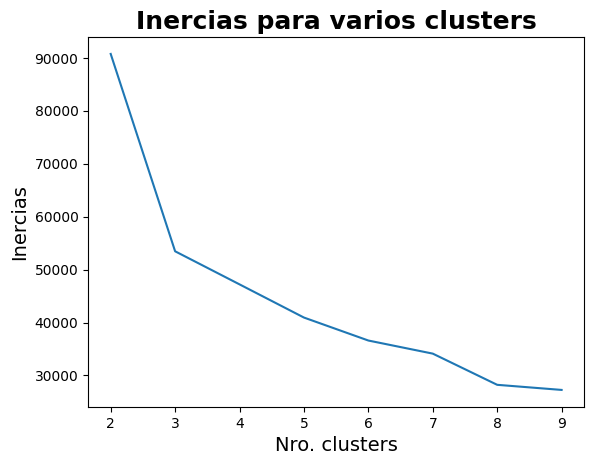

In [22]:
X=data_robust

inertias_robust = []
n_clusters_iterable = range(2,10)
for n_clusters in n_clusters_iterable:
    model_kmeans = KMeans(n_clusters=n_clusters, random_state=29)
    model_kmeans.fit(X)
    inertias_robust.append(model_kmeans.inertia_)

# Usando los datos escalados con la técnica 1 y valor asignado de init
plt.plot(n_clusters_iterable, inertias_robust)
plt.title("Inercias para varios clusters", fontsize=18, fontweight = "bold")
plt.xlabel("Nro. clusters", fontsize=14)
plt.ylabel("Inercias", fontsize=14)
plt.show()

**COMENTARIOS**

Usando los datos escalados con la técnica 2 y valor asignado a init

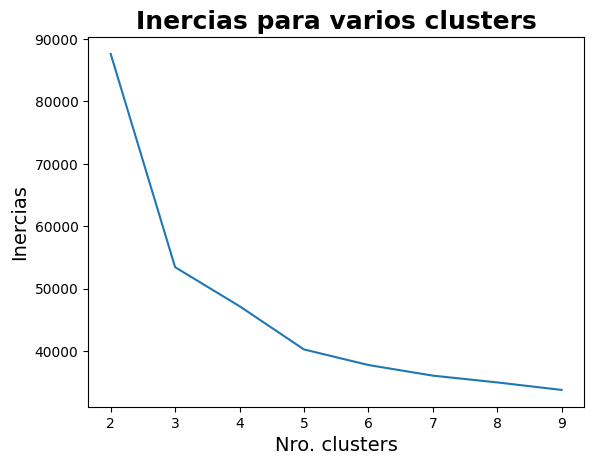

In [23]:
X=data_robust

inertias_robust_random = []
n_clusters_iterable = range(2,10)
for n_clusters in n_clusters_iterable:
    model_kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=29)
    model_kmeans.fit(X)
    inertias_robust_random.append(model_kmeans.inertia_)

# Usando los datos escalados con la técnica 1 y valor asignado de init
plt.plot(n_clusters_iterable, inertias_robust_random)
plt.title("Inercias para varios clusters", fontsize=18, fontweight = "bold")
plt.xlabel("Nro. clusters", fontsize=14)
plt.ylabel("Inercias", fontsize=14)
plt.show()

## **ÍNDICE DE SILHOUETTE**

###(TÉCNICA 1)

**COMENTARIOS**

Usando los datos escalados con la técnica 1 y valor por defecto de init

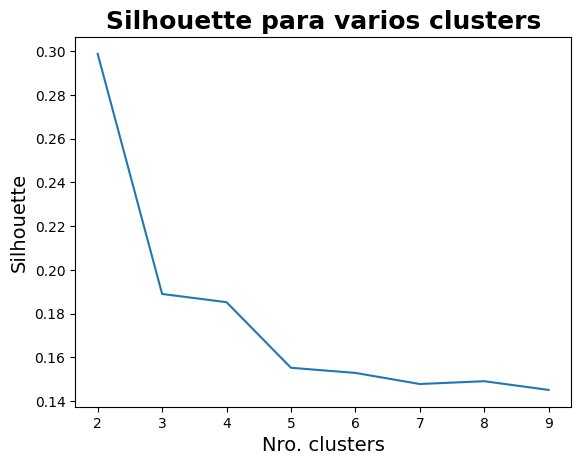

In [32]:
X=data_scaled

silhouette_scores = []
n_clusters_iterable = range(2,10)
for n_clusters in n_clusters_iterable:
    model_kmeans = KMeans(n_clusters=n_clusters, random_state=29) # Instanciamos el algoritmo de k-means
    model_kmeans.fit(X) # Ajustamos el modelo de k-means
    # Esta la dispersión de nuestros grupos
    silhouette_scores.append(silhouette_score(X, model_kmeans.labels_))

plt.plot(n_clusters_iterable, silhouette_scores)
plt.title("Silhouette para varios clusters", fontsize=18, fontweight = "bold")
plt.xlabel("Nro. clusters", fontsize=14)
plt.ylabel("Silhouette", fontsize=14)
plt.show()

**COMENTARIOS**

Usando los datos escalados con la técnica 1 y valor asignado a init

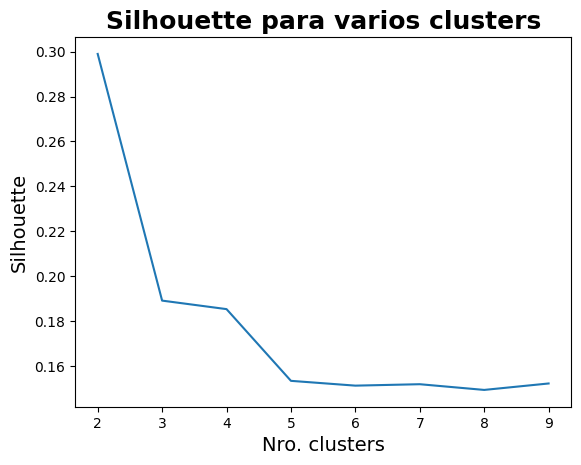

In [33]:
X=data_scaled

silhouette_scores_random = []
n_clusters_iterable = range(2,10)
for n_clusters in n_clusters_iterable:
    model_kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=29) # Instanciamos el algoritmo de k-means
    model_kmeans.fit(X) # Ajustamos el modelo de k-means
    # Esta la dispersión de nuestros grupos
    silhouette_scores_random.append(silhouette_score(X, model_kmeans.labels_))

plt.plot(n_clusters_iterable, silhouette_scores_random)
plt.title("Silhouette para varios clusters", fontsize=18, fontweight = "bold")
plt.xlabel("Nro. clusters", fontsize=14)
plt.ylabel("Silhouette", fontsize=14)
plt.show()

In [34]:
for n_clusters, score in zip(n_clusters_iterable, silhouette_scores):
  print(f"Número de clusters: {n_clusters}, Índice de Silhouette: {score:.4f}")

Número de clusters: 2, Índice de Silhouette: 0.2988
Número de clusters: 3, Índice de Silhouette: 0.1890
Número de clusters: 4, Índice de Silhouette: 0.1853
Número de clusters: 5, Índice de Silhouette: 0.1553
Número de clusters: 6, Índice de Silhouette: 0.1529
Número de clusters: 7, Índice de Silhouette: 0.1479
Número de clusters: 8, Índice de Silhouette: 0.1491
Número de clusters: 9, Índice de Silhouette: 0.1452


In [35]:
for n_clusters, score in zip(n_clusters_iterable, silhouette_scores_random):
  print(f"Número de clusters: {n_clusters}, Índice de Silhouette: {score:.4f}")

Número de clusters: 2, Índice de Silhouette: 0.2990
Número de clusters: 3, Índice de Silhouette: 0.1891
Número de clusters: 4, Índice de Silhouette: 0.1853
Número de clusters: 5, Índice de Silhouette: 0.1533
Número de clusters: 6, Índice de Silhouette: 0.1512
Número de clusters: 7, Índice de Silhouette: 0.1518
Número de clusters: 8, Índice de Silhouette: 0.1493
Número de clusters: 9, Índice de Silhouette: 0.1521


### (TÉCNICA 2)

**COMENTARIOS**

Usando los datos escalados con la técnica 2 y valor por defecto de init

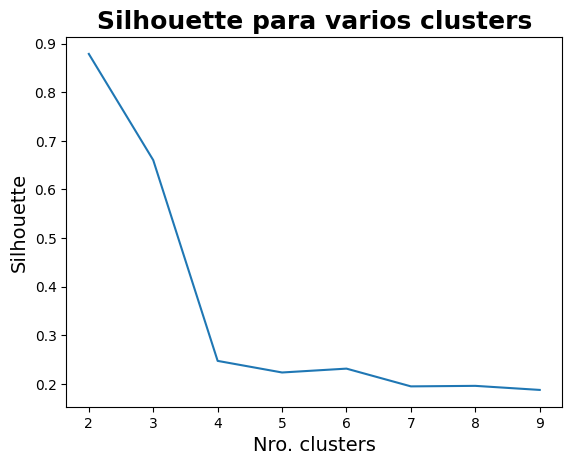

In [36]:
X=data_robust

silhouette_scores_robust = []
n_clusters_iterable = range(2,10)
for n_clusters in n_clusters_iterable:
    model_kmeans = KMeans(n_clusters=n_clusters, random_state=29) # Instanciamos el algoritmo de k-means
    model_kmeans.fit(X) # Ajustamos el modelo de k-means
    # Esta la dispersión de nuestros grupos
    silhouette_scores_robust.append(silhouette_score(X, model_kmeans.labels_))

plt.plot(n_clusters_iterable, silhouette_scores_robust)
plt.title("Silhouette para varios clusters", fontsize=18, fontweight = "bold")
plt.xlabel("Nro. clusters", fontsize=14)
plt.ylabel("Silhouette", fontsize=14)
plt.show()

**COMENTARIOS**

Usando los datos escalados con la técnica 2 y valor asignado a init

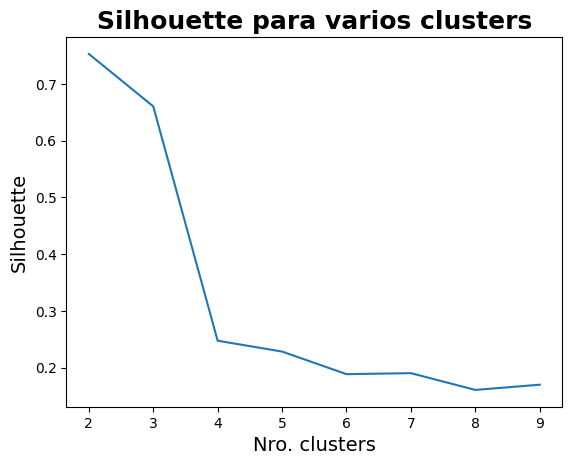

In [37]:
X=data_robust

silhouette_scores_robust_random = []
n_clusters_iterable = range(2,10)
for n_clusters in n_clusters_iterable:
    model_kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=29) # Instanciamos el algoritmo de k-means
    model_kmeans.fit(X) # Ajustamos el modelo de k-means
    # Esta la dispersión de nuestros grupos
    silhouette_scores_robust_random.append(silhouette_score(X, model_kmeans.labels_))

plt.plot(n_clusters_iterable, silhouette_scores_robust_random)
plt.title("Silhouette para varios clusters", fontsize=18, fontweight = "bold")
plt.xlabel("Nro. clusters", fontsize=14)
plt.ylabel("Silhouette", fontsize=14)
plt.show()

In [38]:
for n_clusters, score in zip(n_clusters_iterable, silhouette_scores_robust):
  print(f"Número de clusters: {n_clusters}, Índice de Silhouette: {score:.4f}")

Número de clusters: 2, Índice de Silhouette: 0.8787
Número de clusters: 3, Índice de Silhouette: 0.6602
Número de clusters: 4, Índice de Silhouette: 0.2473
Número de clusters: 5, Índice de Silhouette: 0.2234
Número de clusters: 6, Índice de Silhouette: 0.2314
Número de clusters: 7, Índice de Silhouette: 0.1948
Número de clusters: 8, Índice de Silhouette: 0.1959
Número de clusters: 9, Índice de Silhouette: 0.1875


In [39]:
for n_clusters, score in zip(n_clusters_iterable, silhouette_scores_robust_random):
    print(f"Número de clusters: {n_clusters}, Índice de Silhouette: {score:.4f}")

Número de clusters: 2, Índice de Silhouette: 0.7526
Número de clusters: 3, Índice de Silhouette: 0.6602
Número de clusters: 4, Índice de Silhouette: 0.2474
Número de clusters: 5, Índice de Silhouette: 0.2283
Número de clusters: 6, Índice de Silhouette: 0.1885
Número de clusters: 7, Índice de Silhouette: 0.1903
Número de clusters: 8, Índice de Silhouette: 0.1607
Número de clusters: 9, Índice de Silhouette: 0.1699


# Análisis de los grupos

## Análisis inercia

In [50]:
datos_inercias = {
    'n_clusters': range(2, 10),
    'Tecnica 1 (default)': inertias,
    'Tecnica 1 (random)': inertias_random,
    'Tecnica 2 (default)': inertias_robust,
    'Tecnica 2 (random)': inertias_robust_random
}
inercia_df = pd.DataFrame(datos_inercias)

inercia_df

,n_clusters,Tecnica 1 (default),Tecnica 1 (random),Tecnica 2 (default),Tecnica 2 (random)
0,2,2345.668516,2345.664317,90741.134148,87617.094293
1,3,2083.815869,2083.816000,53454.692360,53454.692360
2,4,1903.239707,1903.226669,47204.999165,47204.896635
3,5,1775.191613,1774.919228,40936.003195,40280.788191
4,6,1685.853787,1683.849448,36595.156274,37786.123009
5,7,1613.047970,1606.184874,34120.920964,36083.524939
6,8,1529.340806,1529.334907,28227.579910,34997.283967
7,9,1476.609183,1464.555590,27263.721918,33793.938355


**COMENTARIOS**

En base a los gráficos y la tabla correspondiente a los valores de cada técnica, la inercia más alta es usando la técnica 2 con valor init default.

Mientras haya una inercia alta significa que los puntos de datos son más dispersos dentro del cluster, es decir, puntos mas alejados/dispersados entre sí.

En cambio, si la inercia es baja quiere decir que los puntos de datos dentro del cluster están cerca unos de otros, formando un grupo bien definido.

## Análisis silhouette

In [49]:
datos_silhouette = {
    'n_clusters': range(2, 10),
    'Tecnica 1 (default)': silhouette_scores,
    'Tecnica 1 (random)': silhouette_scores_random,
    'Tecnica 2 (default)': silhouette_scores_robust,
    'Tecnica 2 (random)': silhouette_scores_robust_random
}
silhouette_df = pd.DataFrame(datos_silhouette)

silhouette_df

,n_clusters,Tecnica 1 (default),Tecnica 1 (random),Tecnica 2 (default),Tecnica 2 (random)
0,2,0.298753,0.298991,0.878722,0.752625
1,3,0.189024,0.189056,0.660239,0.660239
2,4,0.185263,0.185266,0.247276,0.247397
3,5,0.155274,0.153302,0.223409,0.228304
4,6,0.152932,0.151166,0.231353,0.188485
5,7,0.147857,0.151801,0.194840,0.190276
6,8,0.149135,0.149257,0.195906,0.160722
7,9,0.145156,0.152130,0.187546,0.169910


**COMENTARIOS**
En base al gráfico y la tabla, tenemos que:

```
Tecnica 1 (default), Número óptimo de clusters: 2 con índice de 0.29
Tecnica 1 (random), Número óptimo de clusters: 2 con índice de 0.29
Tecnica 2 (default), Número óptimo de clusters: 2 con índice de 0.87
Tecnica 2 (random), Número óptimo de clusters: 2 con índice de 0.75
```



Sabemos que mientras menos clusters mejor, ya que intentamos agrupar de una manera en que los grupos se representen bien entre sí.


De esto, podemos elegir el modelo con el mejor índice, que es la técnica 1 con init default.


In [53]:
data_no_outliers_cleaned['cluster'] = model_kmeans.labels_

In [57]:
cluster_0 = data_no_outliers_cleaned[data_no_outliers_cleaned['cluster'] == 0]
cluster_1 = data_no_outliers_cleaned[data_no_outliers_cleaned['cluster'] == 1]

corr_cluster0 = cluster_0[['rate_marriage', 'age', 'yrs_married']].corr()
corr_cluster1 = cluster_1[['rate_marriage', 'age', 'yrs_married']].corr()

print("Correlación en el Cluster 0:\n\n", corr_cluster0)
print("\nCorrelación en el Cluster 1:\n\n", corr_cluster1)

Correlación en el Cluster 0:

                rate_marriage       age  yrs_married
rate_marriage       1.000000  0.070905     0.086626
age                 0.070905  1.000000     0.872063
yrs_married         0.086626  0.872063     1.000000

Correlación en el Cluster 1:

                rate_marriage       age  yrs_married
rate_marriage       1.000000  0.018259    -0.012149
age                 0.018259  1.000000     0.606015
yrs_married        -0.012149  0.606015     1.000000


In [73]:
descripcion_cluster0 = cluster_0[['rate_marriage', 'age', 'yrs_married']].describe().T
descripcion_cluster1 = cluster_1[['rate_marriage', 'age', 'yrs_married']].describe().T

print("Medidas estadísticas del Cluster 0:\n", descripcion_cluster0)
print("\n Medidas Estadísticas del Cluster 1:\n", descripcion_cluster1)

Medidas estadísticas del Cluster 0:
                count       mean       std   min   25%   50%   75%   max
rate_marriage  629.0   2.481717  0.664188   1.0   2.0   3.0   3.0   3.0
age            629.0  32.878378  6.537611  17.5  27.0  32.0  37.0  42.0
yrs_married    629.0  13.254372  6.875346   0.5   6.0  13.0  16.5  23.0

 Medidas Estadísticas del Cluster 1:
                 count       mean       std   min   25%   50%   75%   max
rate_marriage  1648.0   4.426578  0.633566   3.0   4.0   5.0   5.0   5.0
age            1648.0  24.120146  3.570923  17.5  22.0  22.0  27.0  42.0
yrs_married    1648.0   3.982100  3.030178   0.5   2.5   2.5   6.0  16.5


# Comentarios finales


**CORRELACIÓN**

**Para el cluster 0:**

Entre age y yrs_married, la correlación más alta es de 0.87, lo que de cierta manera tiene sentido, ya que, a mayor edad, es probable que una persona haya estado casada por más tiempo.

**Para el cluster 1:**

La correlación entre age y yrs_married es moderada 0.60, aunque sigue reflejando la misma descripción del cluster 0, aunque un poco menos.

**MEDIDAS ESTADÍSTICAS**

**Para el cluster 0:**
La media de rate_marriage es 2.48, indicando que en este grupo las personas suelen tener una baja valoración para el matrimonio.

En age la media es 33 años, mostrando que este cluster incluye principalmente personas en una edad promedio adulta.

La media de yrs_married es 13 años, mostrando que las personas en este grupo llevan casadas más tiempo en promedio.

**Para el cluster 1:**

La media de rate_marriage más alta es de 4, lo que indica una valoración "buena", a diferencia del cluster del primer grupo.

La media de age es más baja con 24, lo que este grupo indica que  incluye principalmente a personas más jóvenes.

La media de yrs_married es 4 años de casados.

**DISPERSIÓN (desviación estándar)**

**Para el cluster 0:**

La desviación estándar de rate_marriage es de 0.64
En age es de 6.57

En yrs_married es de 6.87

**Para el cluster 1:**

La desviación estándar de rate_marriage es de 0.63 parecido al cluster 0.

En age es de 3.57

En yrs_married es de 3.02

**Comentarios extras:**

En base a este análisis podemos notar que efectivamente los clusters 0 y 1 son distintos, teniendo el cluster 0 a personas de mayor edad y con valoración baja en su matrimonio, y el cluster 1 con personas más jovenes, con menos años de casados y con valoración alta en su matrimonio.